**Run the following two cells before you begin.**

In [2]:
%autosave 10

Autosaving every 10 seconds


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

%matplotlib inline

**First, import the cleaned data set. Then, select the features from the DataFrame of the case study data.**
    
These features should be: `'LIMIT_BAL'`, `'EDUCATION'`, `'MARRIAGE'`, `'AGE'`, `'PAY_1'`, `'BILL_AMT1'`, `'BILL_AMT2'`, `'BILL_AMT3'`, `'BILL_AMT4'`, `'BILL_AMT5'`, `'BILL_AMT6'`, `'PAY_AMT1'`, `'PAY_AMT2'`, `'PAY_AMT3'`, `'PAY_AMT4'`, `'PAY_AMT5'`, AND `'PAY_AMT6'`.

In [4]:
# Import data set
df = pd.read_csv('/Users/priyanshutuli/Downloads/Project-Data-Set-Repository-master/Dataset/cleaned_data.csv')

In [5]:
# Create features list
features = ['LIMIT_BAL', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

_____________________________________________________
**Next, make a 80:20 train/test split using a random seed of 24.**

In [45]:
X = df[features]

In [46]:
y = df['default payment next month']

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 24)

_____________________________________________________
**Then, instantiate the `MinMaxScaler` to scale the data.**

In [10]:
from sklearn.preprocessing import MinMaxScaler

_____________________________________________________
**Next, instantiate a logistic regression model with the `saga` solver, L1 penalty, and set `max_iter` to 1,000 as we want the solver to have enough iterations to find a good solution.**

In [11]:
from sklearn.linear_model import LogisticRegression

_____________________________________________________
**Next, import the `Pipeline` class and create a `Pipeline` with the scaler and the logistic regression model, using the names `'scaler'` and `'model'` for the steps, respectively.**

In [12]:
from sklearn.pipeline import Pipeline

In [13]:
pipe = Pipeline(steps = [('scaler',MinMaxScaler()),('model',LogisticRegression(solver = 'saga',penalty = 'l1', C = 1000))])

_____________________________________________________
**Now, use the `get_params` method to view the parameters from each stage of the pipeline.**

In [14]:
# Use `get_params`
parameters = pipe.get_params()

**Use the `set_params` method to change the the `model__C` parameter to 2.**

In [15]:
# View what `model__C` is set to currently
parameters['model__C']

1000

In [16]:
# Change `model__C` to 2
dict_params = {'model__C':2}
pipe.set_params(**dict_params)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 LogisticRegression(C=2, penalty='l1', solver='saga'))])

_____________________________________________________
**Then, create a smaller range of C values to test with cross-validation, as these models will take longer to train and test with more data than our previous activities.**

**Use C_vals = [$10^2$, $10$, $1$, $10^{-1}$, $10^{-2}$, $10^{-3}$].**


<details>
    <summary>Hint:</summary>
    Recall that exponents in Python use the ** operator.
</details>

In [18]:
C_vals = [10**2, 10, 1, 10 ** -1, 10 ** -2, 10 ** -3]

Now, define `k_folds` using `StratifiedKFold`. The number of folds should be 4. Set the random state to 1.

In [19]:
from sklearn.model_selection import StratifiedKFold

In [23]:
sk_folds = StratifiedKFold(n_splits = 4, random_state = 1)

_____________________________________________________
**Next, make a new version of the `cross_val_C_search` function, called `cross_val_C_search_pipe`. Instead of the model argument, this function will take a pipeline argument. The changes inside the function will be to set the `C` value using `set_params(model__C = <value you want to test>)` on the pipeline, replacing the model with the pipeline for the fit and `predict_proba` methods, and accessing the `C` value using `pipeline.get_params()['model__C']` for the printed status update.**

In [29]:
def cross_val_C_search_pipe(sk_folds, C_vals, pipeline, X, y):
    n_folds = sk_folds.n_splits
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc = [[]] * len(C_vals)
    for c_val_counter in range(len(C_vals)):
        #Set the C value for the model object
        pipeline.set_params(model__C = C_vals[c_val_counter])
        #Count folds for each value of C
        fold_counter = 0
        for train_index, test_index in sk_folds.split(X, y):
            #print(train_index,test_index)
            X_cv_train, X_cv_test = X[train_index], X[test_index]
            y_cv_train, y_cv_test = y[train_index], y[test_index]
            pipeline.fit(X_cv_train,y_cv_train)
            #Get the training ROC AUC
            y_cv_train_predict_proba = pipeline.predict_proba(X_cv_train)
            cv_train_roc_auc[fold_counter, c_val_counter] = roc_auc_score(y_cv_train, y_cv_train_predict_proba[:,1])
            #Testing ROC curves for each fold
            y_cv_test_predict_proba = pipeline.predict_proba(X_cv_test)
            this_fold_roc = roc_curve(y_cv_test, y_cv_test_predict_proba[:,1])
            cv_test_roc[c_val_counter].append(this_fold_roc)
            #Increment the fold counter
            fold_counter += 1
            #Indicate progress
        print('Done with C = {}'.format(pipeline.get_params()['model__C']))
    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc
            
            

_____________________________________________________
**Now, run this function as in the previous activity, but using the new range of `C` values, the pipeline you created, and the features and response variable from the training split of the case study data.**

    You may see warnings here, or in later steps, about the non-convergence of the solver; you could experiment with the `tol` or `max_iter`` options to try and achieve convergence, although the results you obtain with `max_iter = 1000` are likely to be sufficient.

In [30]:
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = cross_val_C_search_pipe(sk_folds, C_vals, pipe, X.values, y.values)

/Users/priyanshutuli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/priyanshutuli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/priyanshutuli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Done with C = 100


/Users/priyanshutuli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/priyanshutuli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/priyanshutuli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Done with C = 10


/Users/priyanshutuli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Done with C = 1
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001


_____________________________________________________
**Plot the average training and testing ROC AUC across folds, for each `np.log(C_vals)` value.**

In [31]:
avg_cv_train_roc_auc = cv_train_roc_auc.mean(axis = 0)
avg_cv_test_roc_auc = cv_test_roc_auc.mean(axis = 0)

Text(0.5, 1.0, 'log(C_vals) vs avg_cv_train_roc_auc')

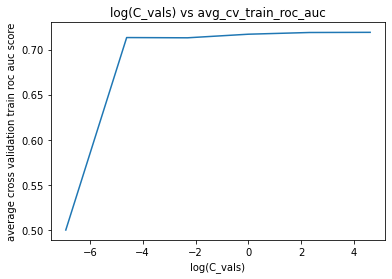

In [32]:
plt.plot(np.log(C_vals), avg_cv_train_roc_auc)
plt.xlabel('log(C_vals)')
plt.ylabel('average cross validation train roc auc score')
plt.title('log(C_vals) vs avg_cv_train_roc_auc')

Text(0.5, 1.0, 'log(C_vals) vs avg_cv_test_roc_auc')

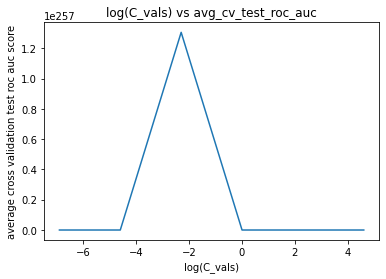

In [61]:
plt.plot(np.log(C_vals), avg_cv_test_roc_auc)
plt.xlabel('log(C_vals)')
plt.ylabel('average cross validation test roc auc score')
plt.title('log(C_vals) vs avg_cv_test_roc_auc')

_____________________________________________________
**Up next, create interaction features for the case study data using scikit-learn's `PolynomialFeatures`. You should use 2 as the degree of polynomial features. Confirm that the number of new features makes sense.**

In [35]:
from sklearn.preprocessing import PolynomialFeatures

In [54]:
pf = PolynomialFeatures(2, interaction_only = True, include_bias = False)

In [55]:
X_new = pf.fit_transform(X)

_____________________________________________________
**Finally, repeat the cross-validation procedure and observe the model performance now.**

In [56]:
# Using the new features, make a 80:20 train/test split using a random seed of 24.**
X_train_poly,X_test_polt,y_train_poly,y_test_poly = train_test_split(X_new,y,test_size = 0.2,random_state = 24)

In [57]:
# Call the cross_val_C_search_pipe() function using the new training data.
# All other parameters should remain the same.
# Note that this training may take a few minutes due to the larger number of features.
cv_train_roc_auc_poly,cv_test_roc_auc_poly,_ = cross_val_C_search_pipe(sk_folds, C_vals, pipe,X_new,y.values)

/Users/priyanshutuli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/priyanshutuli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/priyanshutuli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/priyanshutuli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Done with C = 100


/Users/priyanshutuli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/priyanshutuli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/priyanshutuli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/priyanshutuli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Done with C = 10


/Users/priyanshutuli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/priyanshutuli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/priyanshutuli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/priyanshutuli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Done with C = 1


/Users/priyanshutuli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/priyanshutuli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/priyanshutuli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/priyanshutuli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Done with C = 0.1
Done with C = 0.01
Done with C = 0.001


In [58]:
# Plot the average training and testing ROC AUC across folds, for each C value.
avg_cv_train_roc_auc_poly = cv_train_roc_auc_poly.mean(axis = 0)
avg_cv_test_roc_auc_poly = cv_test_roc_auc_poly.mean(axis = 0)

Text(0.5, 1.0, 'log(C_vals) vs avg_cv_train_roc_auc_poly')

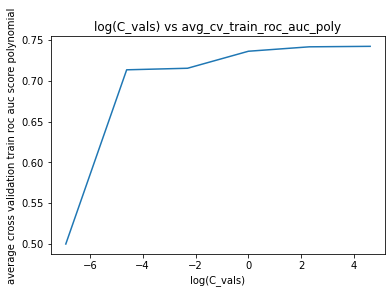

In [59]:
plt.plot(np.log(C_vals), avg_cv_train_roc_auc_poly)
plt.xlabel('log(C_vals)')
plt.ylabel('average cross validation train roc auc score polynomial')
plt.title('log(C_vals) vs avg_cv_train_roc_auc_poly')

Text(0.5, 1.0, 'log(C_vals) vs avg_cv_test_roc_auc_poly')

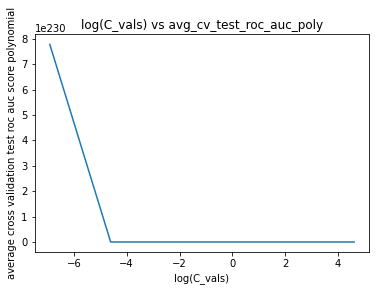

In [60]:
plt.plot(np.log(C_vals), avg_cv_test_roc_auc_poly)
plt.xlabel('log(C_vals)')
plt.ylabel('average cross validation test roc auc score polynomial')
plt.title('log(C_vals) vs avg_cv_test_roc_auc_poly')

**Take a look at the above graph. Does the average cross-validation testing performance improve with the interaction features? Is regularization useful?**